In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2025-01-08 20:24:55.273368: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-08 20:24:57.444580: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# List of data and label files
data_files = ["../data0.npy", "../data1.npy", "../data2.npy"]
label_files = ["../lab0.npy", "../lab1.npy", "../lab2.npy"]

# Initialize empty lists to store the combined data and labels
combined_data = []
combined_labels = []

# Loop through each pair of data and label files
for data_file, label_file in zip(data_files, label_files):
    data = np.load(data_file)
    labels = np.load(label_file)
    combined_data.append(data)
    combined_labels.append(labels)

# Concatenate all data and labels
train_data = np.concatenate(combined_data, axis=0)
train_labels = np.concatenate(combined_labels, axis=0)

# Add channel dimension for grayscale images
train_data = train_data[..., np.newaxis]

# Normalize pixel values to [0,1]
train_data = train_data.astype('float32') / 255.0

print("Combined data shape:", train_data.shape)
print("Combined labels shape:", train_labels.shape)

Combined data shape: (30000, 40, 168, 1)
Combined labels shape: (30000,)


In [3]:
def create_model(input_shape):
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1)  # Single output for sum prediction
    ])
    
    return model

def train_model():
    # Load and preprocess data
    X = train_data
    y = train_labels
    
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create model
    model = create_model(input_shape=X_train.shape[1:])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),  # Mean squared error for regression
        metrics=['mae']  # Mean absolute error for interpretability
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    return model, history

In [4]:
# Train the model
model, history = train_model()

/home2/akj/miniconda3/envs/TCN_tf/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-08 20:25:06.544446: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 80s 411ms/step - loss: 322.9745 - mae: 16.9484 - val_loss: 56.6926 - val_mae: 6.1293
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 76s 402ms/step - loss: 121.2197 - mae: 9.4245 - val_loss: 6262.5312 - val_mae: 78.0289
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 76s 402ms/step - loss: 38.4847 - mae: 4.9314 - val_loss: 169.4031 - val_mae: 9.3130
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 75s 400ms/step - loss: 31.6303 - mae: 4.4798 - val_loss: 37.2123 - val_mae: 4.9943
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 75s 401ms/step - loss: 26.6629 - mae: 4.1170 - val_loss: 16.0428 - val_mae: 3.1908
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 75s 401ms/step - loss: 23.2246 - mae: 3.8371 - val_loss: 21.1436 - val_mae: 3.6893
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 75s 399ms/step - loss: 20.8870 - mae: 3.6475 - val_loss: 12.5908 - val_mae: 2.8088
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 75s 400ms/step - loss: 18.1860 - mae: 3.4140 - val_loss: 38.4968 - val_mae: 5.3722
Epoch 9/1

In [5]:
# Save the model
model.save('digit_sum_model.h5')

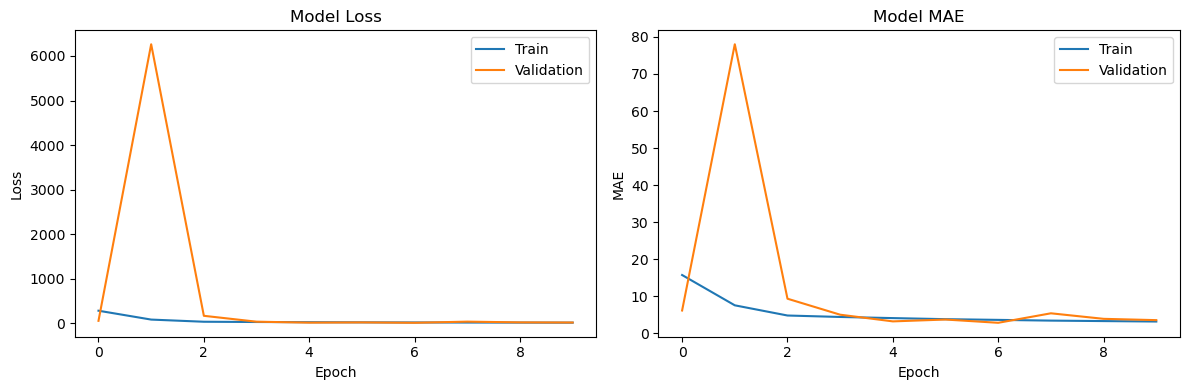

In [6]:
plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()